In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt

In [16]:
def FW_Q(Q, c, x, verbosity, maxit, maxtime, eps, fstop, stopcr):
    """
    Implements the Frank-Wolfe Algorithm for solving a quadratic programming problem.

    The function aims to minimize the objective function:
        0.5 * x^T * Q * x - c^T * x
    subject to the constraints that x lies within the standard simplex.

    Parameters:
    - Q (numpy.ndarray): Positive semidefinite matrix (n x n) in the quadratic term.
    - c (numpy.ndarray): Vector (n x 1) in the linear term.
    - x (numpy.ndarray): Initial solution vector (n x 1) within the simplex.
    - verbosity (int): Controls the level of output detail.
    - maxit (int): Maximum number of iterations.
    - maxtime (float): Maximum allowed runtime in seconds.
    - eps (float): Tolerance for the stopping criterion.
    - fstop (float): Objective function value for early stopping.
    - stopcr (int): Stopping criterion type (1 or 2).

    Returns:
    - x (numpy.ndarray): Optimized solution vector.
    - it (int): Number of iterations performed.
    - fx (float): Final value of the objective function.
    - ttot (float): Total runtime.
    - fh (numpy.ndarray): Array of objective function values over iterations.
    - timeVec (numpy.ndarray): Array of runtimes per iteration.
    """

    gamma = 1e-4  # Parameter for Armijo condition

    flagls = 0  # Flag for line search failure

    _, n = Q.shape  # Dimensions of the problem

    # Initialize function history and time vectors
    if maxit < float('inf'):
        fh = np.zeros(maxit)
        timeVec = np.zeros(maxit)
    else:
        fh = np.zeros(100 * n)
        timeVec = np.zeros(100 * n)

    it = 1  # Iteration counter
    tstart = time.time()  # Start time

    while it <= maxit and flagls == 0:

        # Calculate Qx, xQx, and cx
        Qx = Q @ x
        xQx = x.T @ Qx
        cx = c.T @ x

        if it == 1:
            fx = 0.5 * xQx - cx  # Initial objective function value
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - tstart

        fh[it - 1] = fx  # Store objective function value

        # Gradient evaluation
        g = Qx - c

        if timeVec[it - 1] > maxtime:
            break

        # Solution of FW problem (Frank-Wolfe step)
        istar = np.argmin(g)
        xstar = np.zeros(n)
        xstar[istar] = 1.0

        # Direction calculation
        d = xstar - x
        gnr = g.T @ d

        # Stopping criteria and test for termination
        if stopcr == 1:
            if fx <= fstop:
                break
        elif stopcr == 2:
            if gnr >= -eps:
                break
        else:
            raise ValueError('Unknown stopping criterion')

        # Armijo search
        alpha = 1
        ref = gamma * gnr

        while True:
            # Smart computation of the objective function at the trial point
            fz = 0.5 * ((1 - alpha)**2 * xQx + 2 * alpha * (1 - alpha) * Qx[istar] +
                        alpha**2 * Q[istar, istar]) - ((1 - alpha) * cx + alpha * c[istar])

            if fz <= fx + alpha * ref:
                z = x + alpha * d
                break
            else:
                alpha *= 0.5

            if alpha <= 1e-20:
                z = x
                fz = fx
                flagls = 1
                it -= 1
                break

        x = z
        fx = fz

        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"f(x)     = {fx}")

        it += 1

    ttot = time.time() - tstart  # Total runtime

    if it < len(fh):
        fh = fh[:it]
        timeVec = timeVec[:it]

    return x, it, fx, ttot, fh, timeVec


In [15]:
def FWAW_Q(Q, c, x, verbosity, maxit, maxtime, eps, fstop, stopcr):
    """
    Implements the Frank-Wolfe Algorithm with Away Steps for solving a quadratic programming problem.

    The function aims to minimize the objective function:
        0.5 * x^T * Q * x - c^T * x
    subject to the constraints that x lies within the standard simplex.

    Parameters:
    - Q (numpy.ndarray): Positive semidefinite matrix (n x n) in the quadratic term.
    - c (numpy.ndarray): Vector (n x 1) in the linear term.
    - x (numpy.ndarray): Initial solution vector (n x 1) within the simplex.
    - verbosity (int): Controls the level of output detail.
    - maxit (int): Maximum number of iterations.
    - maxtime (float): Maximum allowed runtime in seconds.
    - eps (float): Tolerance for the stopping criterion.
    - fstop (float): Objective function value for early stopping.
    - stopcr (int): Stopping criterion type (1 or 2).

    Returns:
    - x (numpy.ndarray): Optimized solution vector.
    - it (int): Number of iterations performed.
    - fx (float): Final value of the objective function.
    - ttot (float): Total runtime.
    - fh (numpy.ndarray): Array of objective function values over iterations.
    - timeVec (numpy.ndarray): Array of runtimes per iteration.
    """

    gamma = 1e-4  # Parameter for Armijo condition

    flagls = 0  # Flag for line search failure

    _, n = Q.shape  # Dimensions of the problem

    # Initialize function history and time vectors
    if maxit < float('inf'):
        fh = np.zeros(maxit)
        timeVec = np.zeros(maxit)
    else:
        fh = np.zeros(100 * n)
        timeVec = np.zeros(100 * n)

    it = 1  # Iteration counter
    tstart = time.time()  # Start time

    while it <= maxit and flagls == 0:

        # Calculate Qx, xQx, and cx
        Qx = Q @ x
        xQx = x.T @ Qx
        cx = c.T @ x

        if it == 1:
            fx = 0.5 * xQx - cx  # Initial objective function value
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - tstart

        fh[it - 1] = fx  # Store objective function value

        # Gradient evaluation
        g = Qx - c

        if timeVec[it - 1] > maxtime:
            break

        # Solution of FW problem (Frank-Wolfe step)
        istar = np.argmin(g)
        xstar = np.zeros(n)
        xstar[istar] = 1.0

        # Solution of Away step problem
        indcc = np.where(x > 0)[0]
        istaraw = np.argmax(g[indcc])
        xstar2 = np.zeros(n)
        indaw = indcc[istaraw]
        xstar2[indaw] = 1.0

        # Directions calculation
        dFW = xstar - x
        dAS = x - xstar2

        p1 = g.T @ dFW
        p2 = g.T @ dAS

        # Choice of the search direction
        if p1 <= p2:
            d = dFW
            alpham = 1.0
            gnr = p1
            cdir = 1
        else:
            d = dAS
            alpham = x[indaw] / (1 - x[indaw])
            gnr = p2
            cdir = 2

        # Stopping criteria and test for termination
        if stopcr == 1:
            if fx <= fstop:
                break
        elif stopcr == 2:
            if p1 >= -eps:
                break
        else:
            raise ValueError('Unknown stopping criterion')

        # Armijo search
        alpha = alpham
        ref = gamma * gnr

        while True:
            # Smart computation of the objective function at the trial point
            if cdir == 1:
                fz = 0.5 * ((1 - alpha)**2 * xQx + 2 * alpha * (1 - alpha) * Qx[istar] +
                            alpha**2 * Q[istar, istar]) - ((1 - alpha) * cx + alpha * c[istar])
            else:
                fz = 0.5 * ((1 + alpha)**2 * xQx - 2 * alpha * (1 + alpha) * Qx[indaw] +
                            alpha**2 * Q[indaw, indaw]) - ((1 + alpha) * cx - alpha * c[indaw])

            if fz <= fx + alpha * ref:
                z = x + alpha * d
                break
            else:
                alpha *= 0.5

            if alpha <= 1e-20:
                z = x
                fz = fx
                flagls = 1
                it -= 1
                break

        x = z
        fx = fz

        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"f(x)     = {fx}")

        it += 1

    ttot = time.time() - tstart  # Total runtime

    if it < len(fh):
        fh = fh[:it]
        timeVec = timeVec[:it]

    return x, it, fx, ttot, fh, timeVec


In [ ]:
def proj_simplex_vector(y):
    """
    Projects a vector y onto the standard simplex.

    Parameters:
    - y (numpy.ndarray): Input vector.

    Returns:
    - numpy.ndarray: The projected vector.
    """
    u = np.sort(y)[::-1]
    cssv = np.cumsum(u) - 1
    ind = np.arange(len(y)) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    return np.maximum(y - theta, 0)

In [17]:
def PG_Q(Q, c, x, verbosity, maxit, maxtime, eps, fstop, stopcr):
    """
    Implements the Projected Gradient Algorithm for solving a quadratic programming problem.

    The function aims to minimize the objective function:
        0.5 * x^T * Q * x - c^T * x
    subject to the constraints that x lies within the standard simplex.

    Parameters:
    - Q (numpy.ndarray): Positive semidefinite matrix (n x n) in the quadratic term.
    - c (numpy.ndarray): Vector (n x 1) in the linear term.
    - x (numpy.ndarray): Initial solution vector (n x 1) within the simplex.
    - verbosity (int): Controls the level of output detail.
    - maxit (int): Maximum number of iterations.
    - maxtime (float): Maximum allowed runtime in seconds.
    - eps (float): Tolerance for the stopping criterion.
    - fstop (float): Objective function value for early stopping.
    - stopcr (int): Stopping criterion type (1 or 2).

    Returns:
    - x (numpy.ndarray): Optimized solution vector.
    - it (int): Number of iterations performed.
    - fx (float): Final value of the objective function.
    - ttot (float): Total runtime.
    - fh (numpy.ndarray): Array of objective function values over iterations.
    - timeVec (numpy.ndarray): Array of runtimes per iteration.
    """
    gamma = 1e-4  # Parameter for Armijo condition

    flagls = 0  # Flag for line search failure

    _, n = Q.shape  # Dimensions of the problem

    # Initialize function history and time vectors
    if maxit < float('inf'):
        fh = np.zeros(maxit)
        timeVec = np.zeros(maxit)
    else:
        fh = np.zeros(100 * n)
        timeVec = np.zeros(100 * n)

    it = 1  # Iteration counter
    tstart = time.time()  # Start time

    while it <= maxit and flagls == 0:
        # Calculate Qx, xQx, and cx
        Qx = Q @ x
        xQx = x.T @ Qx
        cx = c.T @ x

        if it == 1:
            fx = 0.5 * xQx - cx  # Initial objective function value
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - tstart

        fh[it - 1] = fx  # Store objective function value

        # Gradient evaluation
        g = Qx - c

        if timeVec[it - 1] > maxtime:
            break

        # Compute direction
        d = proj_simplex_vector(x - g) - x

        # Stopping criteria and test for termination
        if stopcr == 1:
            if fx <= fstop:
                break
        elif stopcr == 2:
            istar = np.argmin(g)
            xstar = np.zeros(n)
            xstar[istar] = 1.0
            if g.T @ (xstar - x) >= -eps:
                break
        else:
            raise ValueError('Unknown stopping criterion')

        # Armijo search
        alpha = 1.0
        gd = g.T @ d
        ref = gamma * gd

        dQd = d.T @ Q @ d

        while True:
            fz = fx + alpha * (gd + 0.5 * alpha * dQd)

            if fz <= fx + alpha * ref:
                z = x + alpha * d
                break
            else:
                alpha *= 0.5

            if alpha <= 1e-20:
                z = x
                flagls = 1
                it -= 1
                break

        x = z
        fx = fz

        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"f(x)     = {fx}")

        it += 1

    ttot = time.time() - tstart  # Total runtime

    if it < len(fh):
        fh = fh[:it]
        timeVec = timeVec[:it]

    return x, it, fx, ttot, fh, timeVec

****************
* AWAY STEP FW *
****************
0.5*xQX - cx = -6.005e+01
Number of non-zero components of x = 20
Number of iterations = 467
CPU time = 5.361e+00
*****************
*  FW STANDARD  *
*****************
0.5*xQX - cx = -6.004e+01
Number of non-zero components of x = 24
Number of iterations = 3001
CPU time = 3.308e+01
*****************
*      PG       *
*****************
0.5*xQX - cx = -6.005e+01
Number of non-zero components of x = 20
Number of iterations = 2759
CPU time = 6.169e+01
****************
* AWAY STEP FW *
****************
0.5*xQX - cx = -5.908e+01
Number of non-zero components of x = 19
Number of iterations = 278
CPU time = 3.272e+00
*****************
*  FW STANDARD  *
*****************
0.5*xQX - cx = -5.907e+01
Number of non-zero components of x = 21
Number of iterations = 3001
CPU time = 3.304e+01
*****************
*      PG       *
*****************
0.5*xQX - cx = -5.908e+01
Number of non-zero components of x = 19
Number of iterations = 2386
CPU time = 5.33

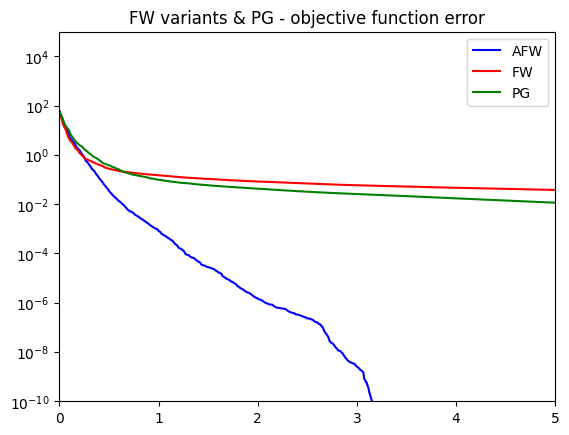

In [21]:
# Number of samples
m = 2 ** 5

# Number of variables
n = 2 ** 12

# Number of runs for each instance
nrun = 5

# Number of solvers
nsolvers = 3

# Maximum number of iterations
maxit = 3000

# Maximum allowed runtime in seconds
maxtime = 100

# Initialize storage for function values and runtimes across runs and solvers
frun_cell = [[None for _ in range(nsolvers)] for _ in range(nrun)]
timeVectot_cell = [[None for _ in range(nsolvers)] for _ in range(nrun)]

# Initialize stopping criteria values
fstop = np.zeros(nrun)

# Loop over each run
for krun in range(nrun):
    # Seed changes at every run to generate a new starting point
    np.random.seed(krun)

    # Initialize starting point on the simplex
    x0 = np.zeros(n)
    x0[0] = 1.0

    # Generate problem instance: Q and c
    Q = np.random.randn(m, n)
    c = np.sum(Q ** 2, axis=0)
    Q = 2.0 * (Q.T @ Q)

    count = 0
    eps = 1e-6
    stopcr = 2

    print("****************")
    print("* AWAY STEP FW *")
    print("****************")

    # Run the Away-Step Frank-Wolfe algorithm
    xfwaw, iterfwaw, fxfwaw, tottimefwaw, frun_cell[krun][count], timeVectot_cell[krun][count] = FWAW_Q(Q, c, x0, 0, maxit,
                                                                                                        maxtime, eps,
                                                                                                        fstop[krun], stopcr)

    # Print results for Away-Step Frank-Wolfe
    print(f"0.5*xQX - cx = {fxfwaw:.3e}")
    print(f"Number of non-zero components of x = {np.sum(np.abs(xfwaw) >= 0.0001)}")
    print(f"Number of iterations = {iterfwaw}")
    print(f"CPU time = {tottimefwaw:.3e}")

    count += 1

    print("*****************")
    print("*  FW STANDARD  *")
    print("*****************")

    # Run the Standard Frank-Wolfe algorithm
    xfw, iterfw, fxfw, tottimefw, frun_cell[krun][count], timeVectot_cell[krun][count] = FW_Q(Q, c, x0, 0, maxit,
                                                                                                maxtime, eps,
                                                                                                fstop[krun], stopcr)

    # Print results for Standard Frank-Wolfe
    print(f"0.5*xQX - cx = {fxfw:.3e}")
    print(f"Number of non-zero components of x = {np.sum(np.abs(xfw) >= 0.0001)}")
    print(f"Number of iterations = {iterfw}")
    print(f"CPU time = {tottimefw:.3e}")

    count += 1

    print("*****************")
    print("*      PG       *")
    print("*****************")

    # Run the Projected Gradient algorithm
    x_pg, iter_pg, fx_pg, tottime_pg, frun_cell[krun][count], timeVectot_cell[krun][count] = PG_Q(Q, c, x0, 0, maxit,
                                                                                                    maxtime, eps,
                                                                                                    fstop[krun], stopcr)

    # Print results for Projected Gradient
    print(f"0.5*xQX - cx = {fx_pg:.3e}")
    print(f"Number of non-zero components of x = {np.sum(np.abs(x_pg) >= 0.0001)}")
    print(f"Number of iterations = {iter_pg}")
    print(f"CPU time = {tottime_pg:.3e}")

    # Update stopping criteria
    fstop[krun] = min([fxfwaw, fxfw, fx_pg])

# Determine the maximum number of iterations across all runs and solvers
maxit = 0
for i in range(nsolvers):
    for krun in range(nrun):
        maxit = max(maxit, len(frun_cell[krun][i]))

# Initialize arrays for function values and runtimes
frun = np.zeros((nrun, nsolvers, maxit))
timerun = np.zeros((nrun, nsolvers, maxit))

# Collect function values and runtimes for each solver and run
for i in range(nsolvers):
    for krun in range(nrun):
        niter = len(frun_cell[krun][i])
        fx = frun_cell[krun][i][-1]
        t = timeVectot_cell[krun][i][-1]
        frun[krun, i, :niter] = frun_cell[krun][i]
        frun[krun, i, niter:] = fx
        timerun[krun, i, :niter] = timeVectot_cell[krun][i]
        timerun[krun, i, niter:] = t

# Cleanup to save memory
del frun_cell, timeVectot_cell, Q, c

# Calculate average function values and runtimes across runs for each solver
frun_plot = np.zeros((nsolvers, maxit))
timerun_plot = np.zeros((nsolvers, maxit))
for i in range(nsolvers):
    for krun in range(nrun):
        frun_plot[i, :] += np.maximum(0, frun[krun, i, :] - fstop[krun])
        timerun_plot[i, :] += timerun[krun, i, :]
frun_plot /= nrun
timerun_plot /= nrun

# Define a threshold to avoid plotting extremely small values
plot_threshold = 1e-20

# Prepare data for plotting
# AFW
plot_fwaw = np.maximum(frun_plot[0, :maxit], plot_threshold)
plot_tfwaw = timerun_plot[0, :maxit]

# FW
plotfw = np.maximum(frun_plot[1, :maxit], plot_threshold)
plottfw = timerun_plot[1, :maxit]

# PG
plot_pg = np.maximum(frun_plot[2, :maxit], plot_threshold)
plot_tpg = timerun_plot[2, :maxit]

# Plot results for all solvers
plt.figure()
plt.semilogy(plot_tfwaw, plot_fwaw, 'b-', label='AFW')
plt.semilogy(plottfw, plotfw, 'r-', label='FW')
plt.semilogy(plot_tpg, plot_pg, 'g-', label='PG')
plt.title('FW variants & PG - objective function error')
plt.legend(['AFW', 'FW', 'PG'])
plt.xlim([0, 5])
plt.ylim([1e-10, 1e5])
plt.savefig(f'Plot_m_{m}_n_{n}_all_solvers.png')
plt.show()
